(31962, 3)
(17197, 2)


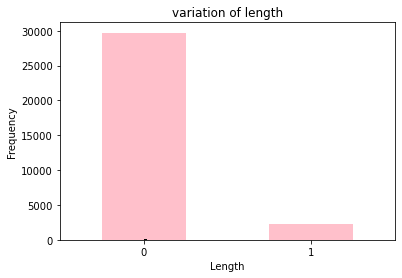

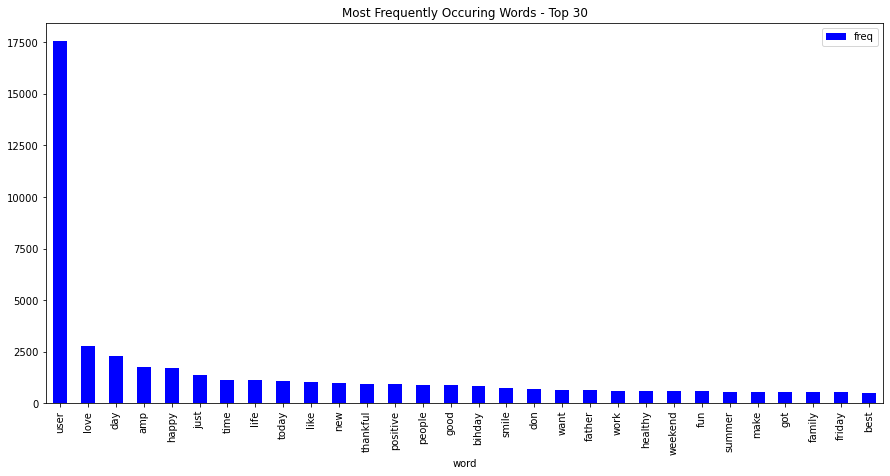

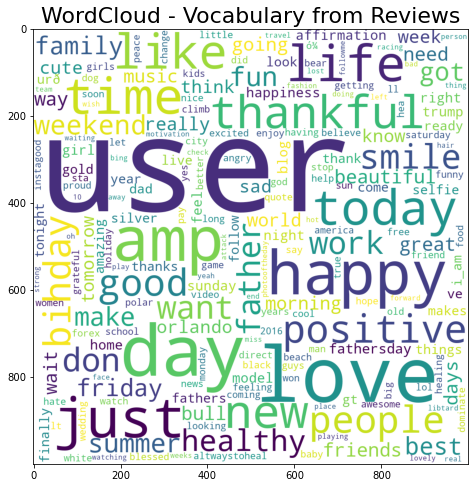

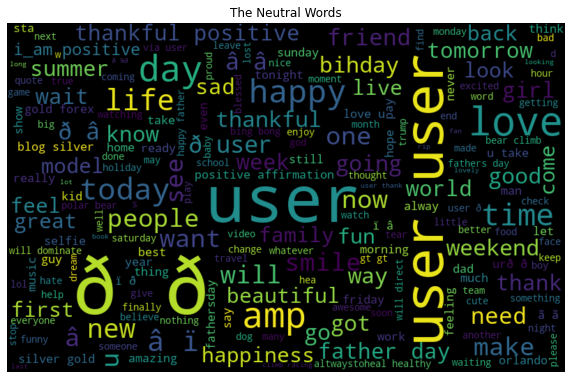

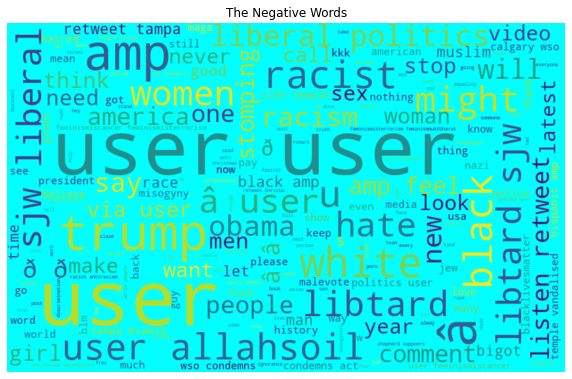

NameError: name 're' is not defined

In [11]:
!pip install wordcloud
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

train = pd.read_csv("C:/Users/shekh/Desktop/kaggle/train_tweet.csv")
test = pd.read_csv("C:/Users/shekh/Desktop/kaggle/test_tweets.csv")

print(train.shape)
print(test.shape)

train.head()

test.head()

train.isnull().any()
test.isnull().any()

# checking out the negative comments from the train set

train[train['label'] == 0].head(10)

# checking out the postive comments from the train set 

train[train['label'] == 1].head(10)

train['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

# checking the distribution of tweets in the data

length_train = train['tweet'].str.len().plot.hist(color = 'pink', figsize = (6, 4))
length_test = test['tweet'].str.len().plot.hist(color = 'orange', figsize = (6, 4))

# adding a column to represent the length of the tweet

train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

train.head(10)

train.groupby('label').describe()

train.groupby('len').mean()['label'].plot.hist(color = 'black', figsize = (6, 4),)
plt.title('variation of length')
plt.xlabel('Length')
plt.show()

from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")

from wordcloud import WordCloud

wordcloud = WordCloud(background_color = 'white', width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("WordCloud - Vocabulary from Reviews", fontsize = 22)

normal_words =' '.join([text for text in train['tweet'][train['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Neutral Words')
plt.show()

negative_words =' '.join([text for text in train['tweet'][train['label'] == 1]])

wordcloud = WordCloud(background_color = 'cyan', width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

# collecting the hashtags

def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

# extracting hashtags from non racist/sexist tweets
HT_regular = hashtag_extract(train['tweet'][train['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

# tokenizing the words present in the training set
tokenized_tweet = train['tweet'].apply(lambda x: x.split()) 

# importing gensim
import gensim

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tweet']), epochs=20)

model_w2v.wv.most_similar(positive = "dinner")

model_w2v.wv.most_similar(positive = "cancer")

model_w2v.wv.most_similar(positive = "apple")

model_w2v.wv.most_similar(negative = "hate")

from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models.doc2vec import LabeledSentence

def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

# label all the tweets
labeled_tweets = add_label(tokenized_tweet)

labeled_tweets[:6]

# removing unwanted patterns from the data

import re
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

train_corpus = []

for i in range(0, 31962):
  review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
# stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
 # joining them back with space
  review = ' '.join(review)
  train_corpus.append(review)

test_corpus = []

for i in range(0, 17197):
  review = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
  review = review.lower()
  review = review.split()
  
  ps = PorterStemmer()
  
# stemming
  review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
  
  # joining them back with space
  review = ' '.join(review)
  test_corpus.append(review)

# creating bag of words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus).toarray()
y = train.iloc[:, 1]

print(x.shape)
print(y.shape)

# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)
x_test = cv.fit_transform(test_corpus).toarray()

print(x_test.shape)

# splitting the training data into train and valid sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

# standardization

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_valid = sc.transform(x_valid)
x_test = sc.transform(x_test)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("F1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

from sklearn.svm import SVC

model = SVC()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)

from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

print("Training Accuracy :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))

# calculating the f1 score for the validation set
print("f1 score :", f1_score(y_valid, y_pred))

# confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print(cm)